In [1]:
#########
# BASIC #
#########
import os
import sys
import platform
import warnings
from datetime import datetime
from collections import Counter
import calendar
from tqdm.notebook import tqdm_notebook

#############
# LOAD DATA #
#############
import numpy as np
import pandas as pd

#############################
# EXPLORATORY DATA ANALYSIS #
#############################
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

######################
# DATA PREPROCESSING #
######################
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
## NATURAL LANGUAGE PROCESSING 
from konlpy.tag import Komoran
from gensim.models import Word2Vec

#######################
# FEATURE ENGINEERING #
#######################
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#####################
# FEATURE SELECTION #
#####################


############
# MODELING #
############
## MACHINE LEARNING
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## DEEP LEARNING
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import joblib
import pickle

###########
# TESTING #
###########
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.4f}'.format
# plt.style.use('ggplot')
if platform.platform().split('-')[0] == 'Windows':
    mpl.rcParams['font.family'] = 'Malgun Gothic' # Windows에서는 한글이 나오게 하기 위해서
else: # macOS라고 가정
    mpl.rcParams['font.family'] = 'AppleGothic' # mac에서는 한글이 나오게 하기 위해서

mpl.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
device = 'cuda'  if torch.cuda.is_available() else 'cpu'

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
learning_rate = 1e-4

In [4]:
data = dict()

In [5]:
data['train'] = pd.read_excel(r'../../data/01_제공데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx',
                       header=1,
                       names=['방송일시', '노출(분)', '마더코드', '상품코드',
                              '상품명', '상품군', '판매단가', '취급액'],
                       thousands=',',
                       )
data['train'].index = pd.to_datetime(data['train']['방송일시'])
data['train'] = data['train'].drop('방송일시',axis=1)
data['train'] = data['train']['2019']
data['train']

,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
방송일시,,,,,,,
2019-01-01 06:00:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0000
2019-01-01 06:00:00,nan,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0000
2019-01-01 06:20:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0000
2019-01-01 06:20:00,nan,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0000
2019-01-01 06:40:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0000
...,...,...,...,...,...,...,...
2019-12-31 23:20:00,nan,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,1664000.0000
2019-12-31 23:40:00,20.0000,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,9149000.0000
2019-12-31 23:40:00,nan,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,15282000.0000


In [6]:
data['train']['연'] = data['train'].index.map(lambda x: x.year)
data['train']['월'] = data['train'].index.map(lambda x: x.month)
data['train']['주'] = data['train'].index.map(lambda x: x.week)
data['train']['일'] = data['train'].index.map(lambda x: x.day)
data['train']['시'] = data['train'].index.map(lambda x: x.hour)
data['train']['분'] = data['train'].index.map(lambda x: x.minute)
data['train']['요일'] = data['train'].index.map(lambda x: calendar.day_abbr[x.weekday()])
data['train']['주'] = data['train'].index.map(lambda x: x.week)

In [7]:
# 노출시간이 비어있을땐 앞을 보면 됨
data['train'] = data['train'].fillna(method='ffill')

# Matplotlib Settings

In [8]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# 상품군별 총 취급액 내에서 비율

In [333]:
df = data['train'][data['train'] != '무형'].pivot_table(values=['취급액'],
                   index=['상품군'],
                   aggfunc='mean').sort_values(by='취급액',ascending=True)

In [339]:
df.index

Index(['침구', '가구', '잡화', '생활용품', '가전', '주방', '의류', '건강기능', '속옷', '이미용', '농수축'], dtype='object', name='상품군')

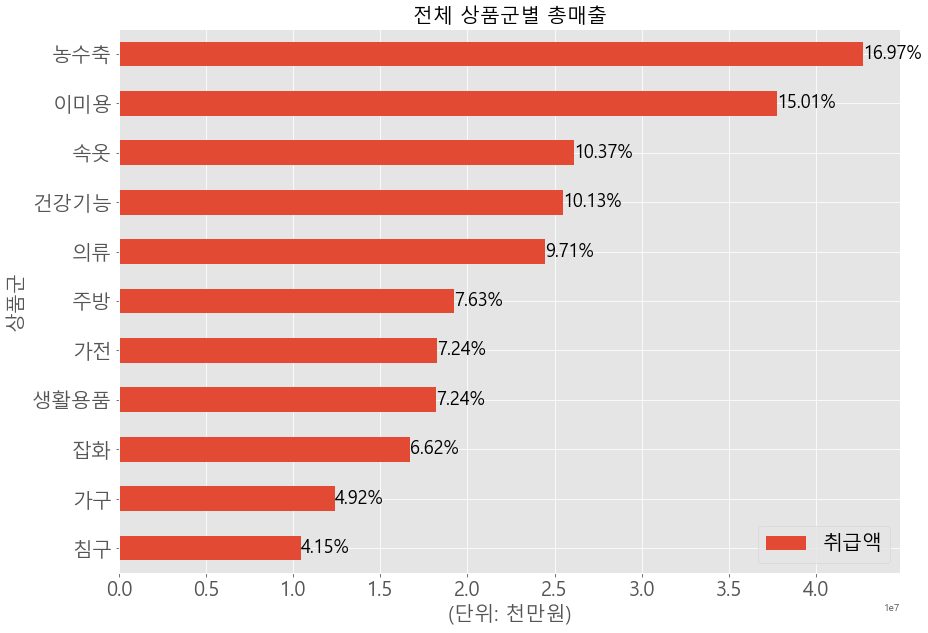

In [351]:
ax = df.plot(kind='barh', figsize=(14, 10))
ax.set_alpha(0.8)
ax.set_title("전체 상품군별 총매출", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel("(단위: 천만원)", fontsize=20)
ax.set_ylabel("상품군", fontsize=20)
ax.legend(prop={'size': 20})

totals = []
for i in ax.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_width(), i.get_y()+.15, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=18, color='black')
plt.summer()
    #plt.savefig('상품군별 총 취급액 내 비율.png')

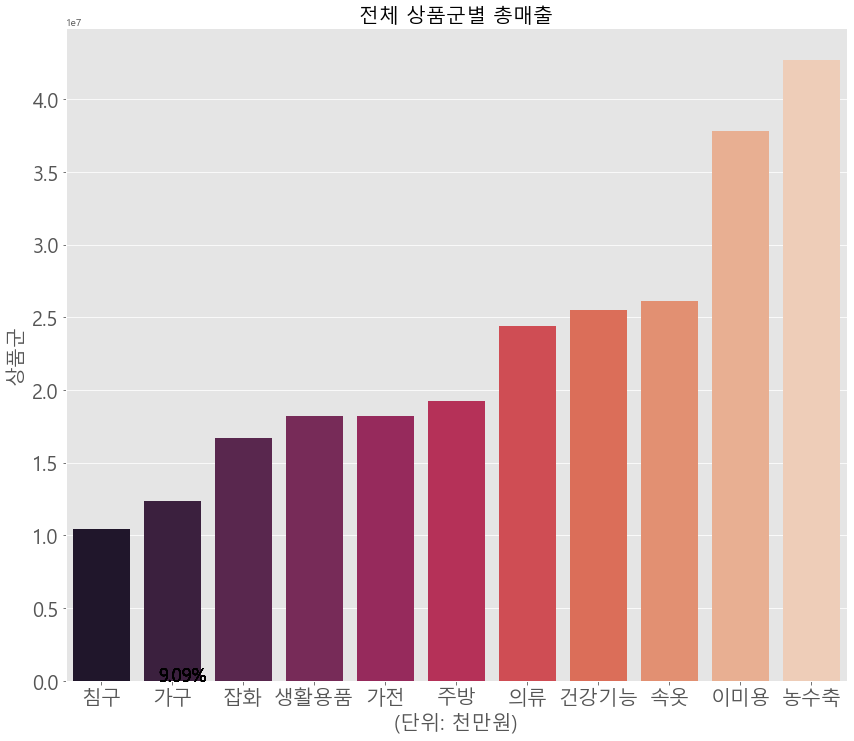

In [353]:
plt.figure(figsize=(14, 12))
ax = sns.barplot(data=df, x=df.index, y='취급액', palette=('rocket'),)
#ax = df.plot(kind='barh', figsize=(14, 10))
ax.set_alpha(0.8)
ax.set_title("전체 상품군별 총매출", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel("(단위: 천만원)", fontsize=20)
ax.set_ylabel("상품군", fontsize=20)
#ax.legend(prop={'size': 20})

totals = []
for i in ax.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_width(), i.get_y(), \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=18, color='black')
plt.summer()

# 상품군 별 판매단가 평균-표준편차

In [57]:
data['train'].판매단가.max()

7930000

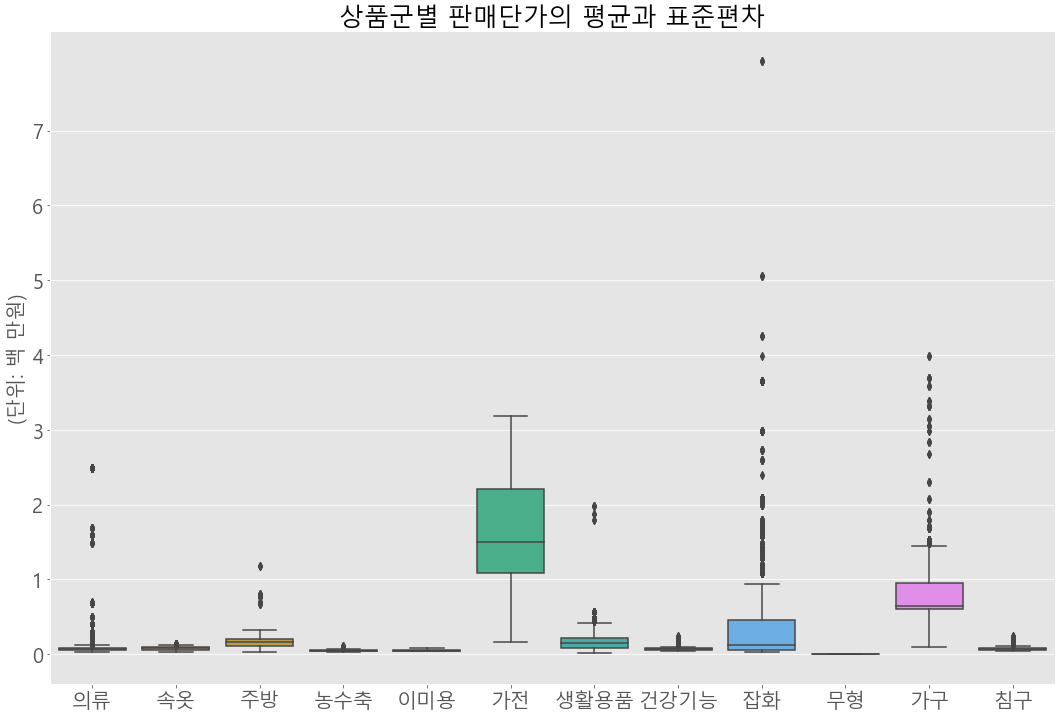

<Figure size 432x288 with 0 Axes>

In [81]:
plt.figure(figsize=(18,12))
sns.boxplot(x = '상품군', y = '판매단가', data = data['train'])
plt.title('상품군별 판매단가의 평균과 표준편차', fontsize=25)
plt.xlabel('', fontsize=20)
plt.ylabel('(단위: 백 만원)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(np.arange(0, 8000000, step=1e+6),
           [f'{str(x)[:1]}' for x in np.arange(0, 8000000, step=1e+6)],
           fontsize=20)
plt.show()
plt.savefig('상품군별 판매단가의 평균과 표준편차 - 전체.png')

In [67]:
small_cat = ['의류', '속옷', '주방', '농수축', '이미용', '생활용품', '건강기능', '침구']
big_cat = ['가전', '잡화', '가구']

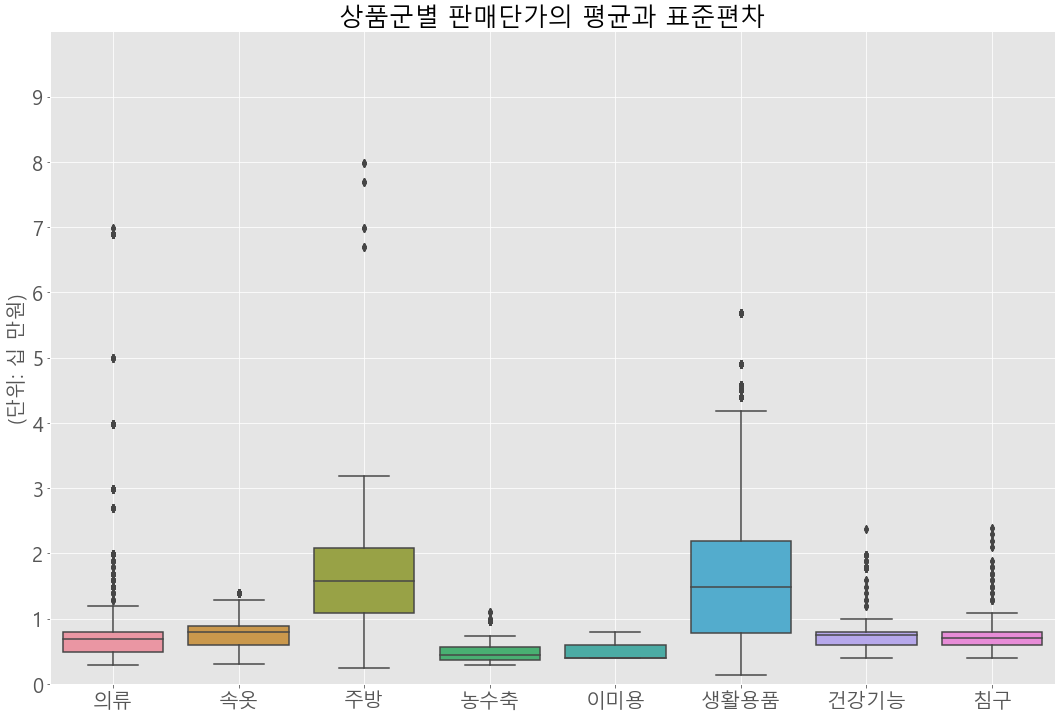

<Figure size 432x288 with 0 Axes>

In [82]:
plt.figure(figsize=(18,12))
sns.boxplot(x = '상품군', y = '판매단가', data=data['train'][data['train'].상품군.map(lambda x: x in small_cat)])
plt.title('상품군별 판매단가의 평균과 표준편차', fontsize=25)
plt.xlabel('', fontsize=20)
plt.ylabel('(단위: 십 만원)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(np.arange(0, 1000000, step=1e+5),
           [f'{str(x)[:1]}' for x in np.arange(0, 1000000, step=1e+5)],
           fontsize=20)
plt.ylim(0, 1000000)
plt.grid(True)
plt.show()
plt.savefig('상품군별 판매단가의 평균과 표준편차 - 작은 단위.png')

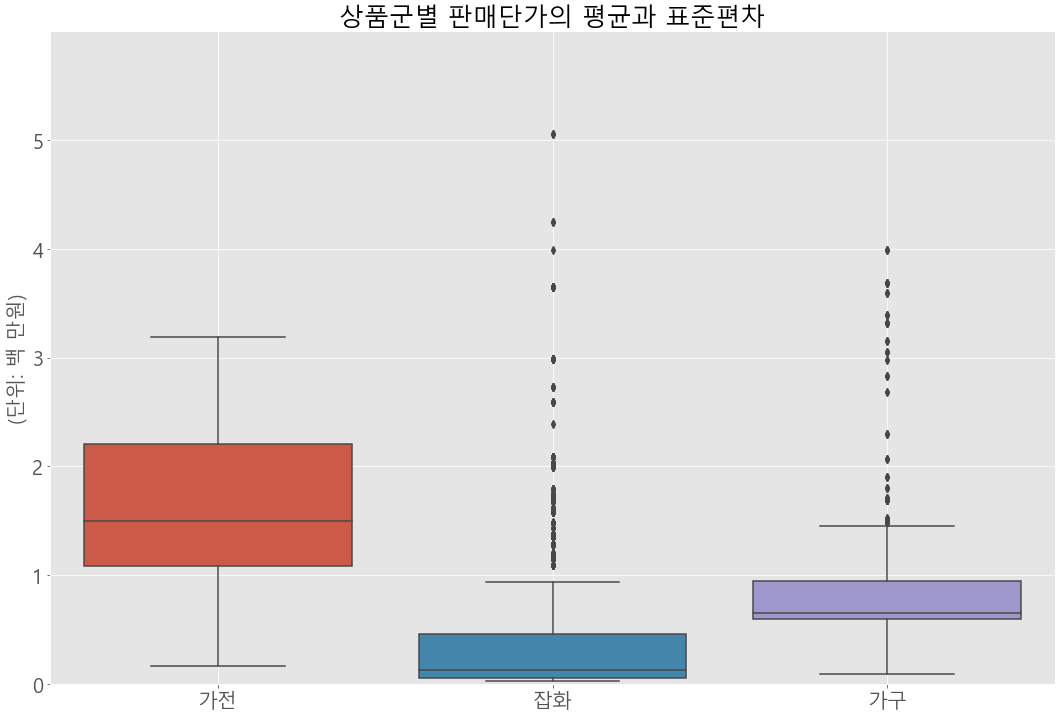

In [356]:
plt.figure(figsize=(18,12))
sns_plot = sns.boxplot(x = '상품군', y = '판매단가', data=data['train'][data['train'].상품군.map(lambda x: x in big_cat)])
plt.title('상품군별 판매단가의 평균과 표준편차', fontsize=25)
plt.xlabel('', fontsize=20)
plt.ylabel('(단위: 백 만원)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(np.arange(0, 6000000, step=1e+6),
           [f'{str(x)[:1]}' for x in np.arange(0, 6000000, step=1e+6)],
           fontsize=20)
plt.ylim(0, 6000000)
plt.grid(True)
plt.show()

# 상품군별 전체 취급액의 누계/평균

ValueError: Invalid RGBA argument: 'j'

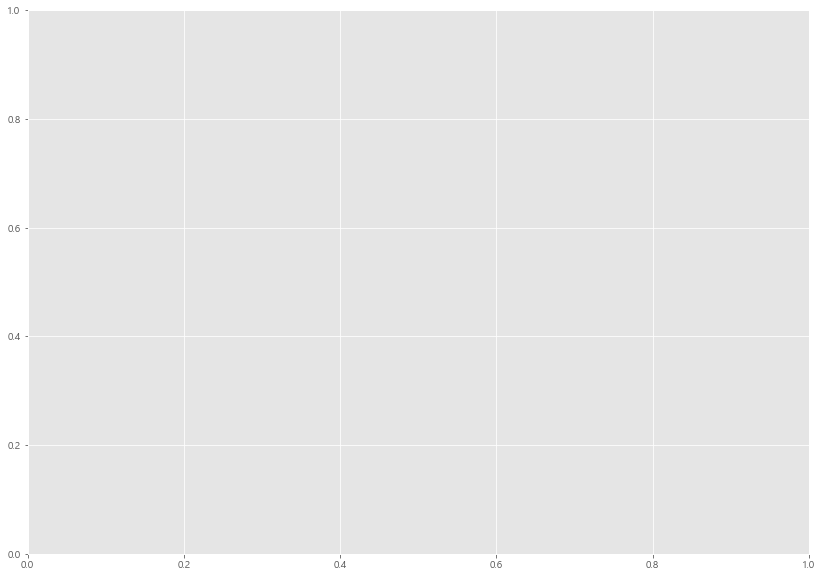

In [355]:
data['train'][data['train'].상품군!='무형'].pivot_table(values=['취급액'],
                   index=['상품군'],
                   aggfunc='sum').sort_values(by='취급액',ascending=False).plot(
    kind='barh', figsize=(14, 10), color=('jet'))
plt.title('상품군별 전체 취급액의 누계', fontsize=25)
plt.ylabel('', fontsize=20)
plt.xlabel('(단위: 백 억원)', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(np.arange(0, 1.7e+11, step=1e+10),
           [f'{x*1e-11:.1f}' for x in np.arange(0, 1.7e+11, step=1e+10)],
           fontsize=20)
#plt.ylim(0, 6000000)
plt.grid(True)
plt.legend(prop={'size': 20})
plt.show()
plt.savefig('상품군별 전체 취급액의 누계.png', bbox_inches='tight')

# 상품군별 방영횟수

비율을 추가해볼까

In [133]:
df = data['train'][['상품코드','상품명','상품군']]['상품군'].value_counts()

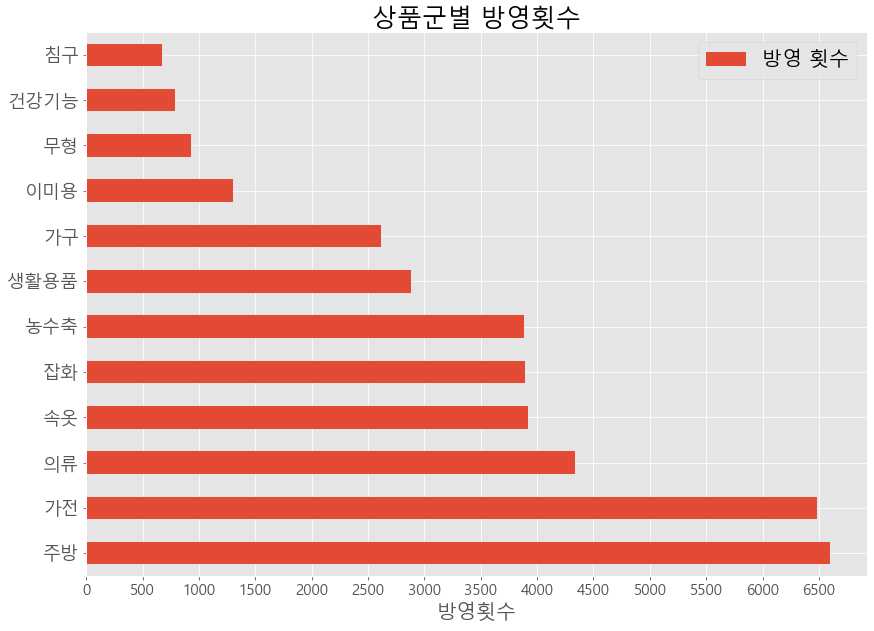

In [134]:
df.plot(kind = 'barh', figsize=(14, 10))
plt.title('상품군별 방영횟수', fontsize=25)
plt.xlabel('방영횟수', fontsize=20)
plt.xticks(np.arange(0, 7000, step=500), np.arange(0, 7000, step=500),
          fontsize=15)
plt.yticks(fontsize=18)
plt.legend(labels=['방영 횟수'], prop={'size':20})
plt.show()

# 상품군별 총 취급액의 평균 및 표준편차

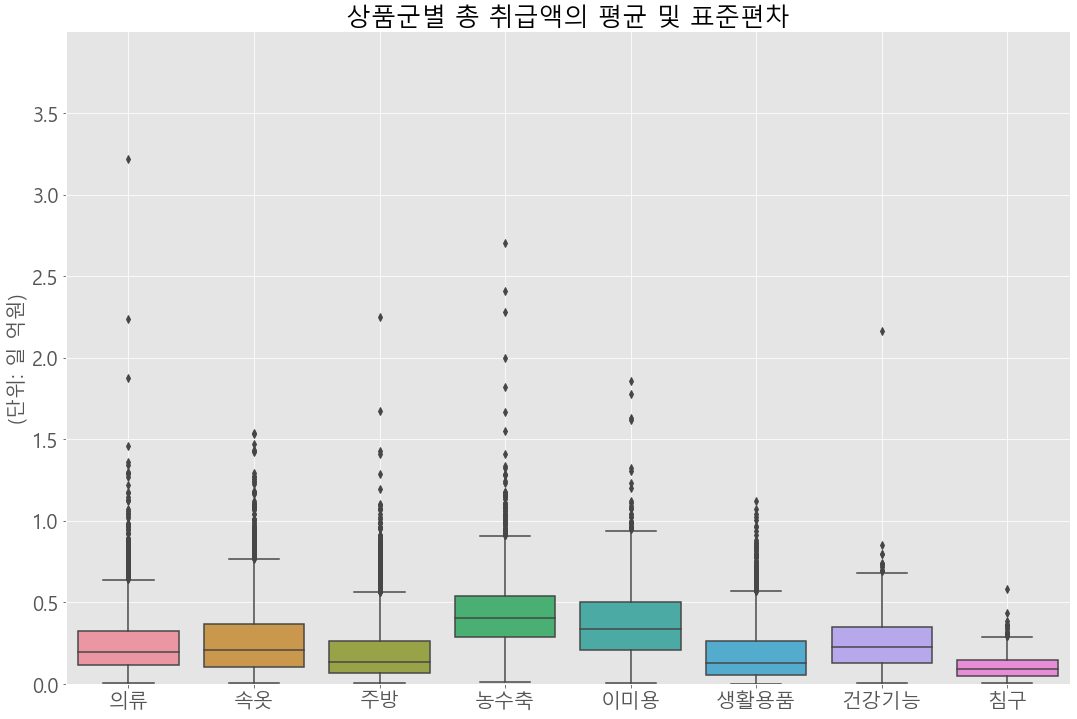

In [159]:
plt.figure(figsize=(18,12))
sns.boxplot(x='상품군', y='취급액', data=data['train'][data['train'].상품군.map(lambda x: x in small_cat)])
plt.title('상품군별 총 취급액의 평균 및 표준편차', fontsize=25)
plt.xlabel('', fontsize=20)
plt.ylabel('(단위: 일 억원)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(np.arange(0, 4*1e+8, step=5e+7),
           [f'{x/1e+8:.1f}' for x in np.arange(0, 4*1e+8, step=5e+7)],
           fontsize=20)
plt.ylim(0, 4*1e+8)
plt.grid(True)
plt.show()

# 상품군별 취급액 평균 비교 그래프

In [242]:
data['train'] = data['train'][data['train'].상품군 != '무형']

<Figure size 1440x864 with 0 Axes>

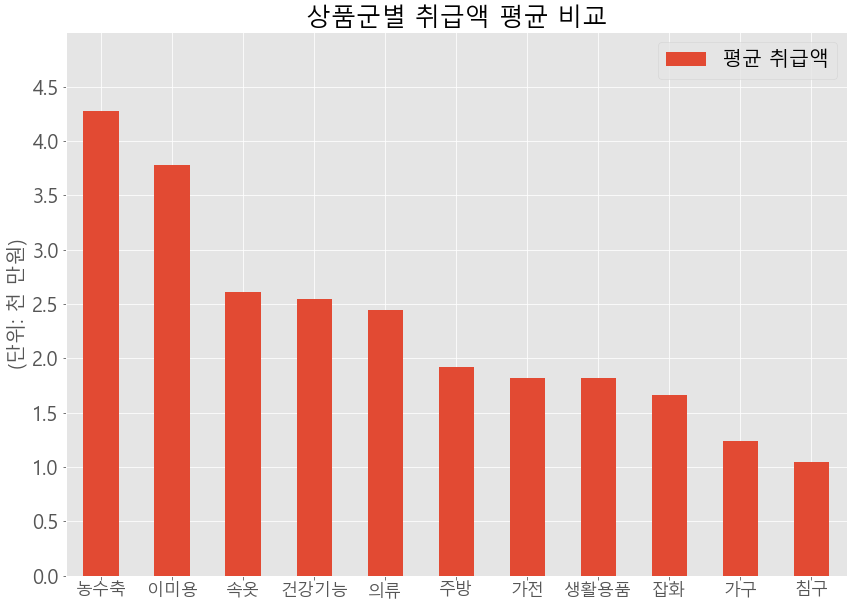

In [243]:
plt.figure(figsize=(20,12))
cat_outcome = data['train'][['상품군', '취급액']].groupby('상품군').mean()
cat_outcome.sort_values(by=['취급액'], axis=0, ascending=False).plot(kind='bar', figsize=(14, 10))
plt.title('상품군별 취급액 평균 비교', fontsize=25)
plt.xlabel('', fontsize=20)
plt.ylabel('(단위: 천 만원)', fontsize=20)
plt.xticks(fontsize=17, rotation=0)
plt.yticks(np.arange(0, 5e+7, step=5e+6),
           [f'{x/1e+7:.1f}' for x in np.arange(0, 5e+7, step=5e+6)],
           fontsize=20)
plt.ylim(0, 5e+7)
plt.grid(True)
plt.legend(labels=['평균 취급액'], prop={'size':20})
plt.show()

# 월별, 주별, 일별, 시간별, 요일별 매출 누계/평균 그래프

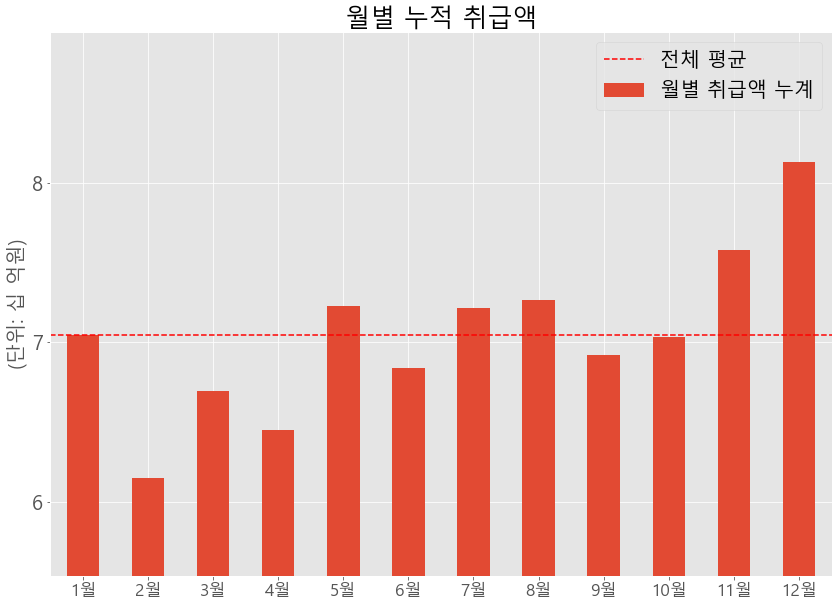

In [244]:
month_group = data['train']['2019'].groupby('월').sum()
month_group['취급액'].plot(kind='bar', figsize=(14, 10))
plt.axhline(y = np.mean(month_group.취급액), color = 'red', ls = '--')
plt.title('월별 누적 취급액', fontsize=25)
plt.xlabel('', fontsize=20)
plt.ylabel('(단위: 십 억원)', fontsize=20)
plt.xticks(ticks=[x-1 for x in range(1, 13)],
           labels=[f'{x}월' for x in range(1, 13)],
           fontsize=17, rotation=0)
plt.yticks(np.arange(0, 1e+11, step=1e+10),
           [f'{x/1e+10:.0f}' for x in np.arange(0, 1e+11, step=1e+10)],
           fontsize=20)
plt.grid(True)
plt.legend(labels=['전체 평균', '월별 취급액 누계'], prop={'size':20})
plt.ylim(month_group['취급액'].min()*0.9, month_group['취급액'].max()*1.1)
plt.show()

In [301]:
cm.Pastel1

In [326]:
month_group = data['train']['2019'].groupby('월').mean()
month_group['col'] = [i for i in range(1, 13)]

In [327]:
month_group['취급액']

월
1    24492530.0660
2    21860641.3082
3    20616355.6034
4    18888221.5060
5    20300416.1281
6    22699218.1999
7    21572533.3333
8    23166352.2474
9    22117738.0876
10   22861951.8699
11   27273330.3347
12   27247964.8123
Name: 취급액, dtype: float64

In [328]:
month_group

,노출(분),마더코드,상품코드,판매단가,취급액,연,주,일,시,분,col
월,,,,,,,,,,,
1,20.4525,100463.0191,201463.0702,383512.8606,24492530.0660,2019.0000,2.8728,16.0907,14.2023,19.7428,1
2,20.3787,100458.1809,201456.0743,454255.7057,21860641.3082,2019.0000,7.0416,14.3996,14.3509,19.8045,2
3,20.7105,100432.3716,201344.3531,442615.2555,20616355.6034,2019.0000,11.2358,15.8861,14.2485,19.8091,3
4,20.3593,100393.3071,201220.4905,618784.1635,18888221.5060,2019.0000,15.5942,14.9918,14.6613,19.8828,4
5,20.1885,100340.3012,201058.6999,674613.9225,20300416.1281,2019.0000,19.8918,15.2439,14.6766,19.9550,5
6,20.5430,100343.2956,201054.4759,439269.9934,22699218.1999,2019.0000,24.2600,15.0531,14.1950,20.3188,6
7,20.6230,100326.8547,201013.6544,506604.3498,21572533.3333,2019.0000,28.7223,15.8583,14.4278,19.8505,7
8,20.6958,100405.3067,201249.7415,526453.9528,23166352.2474,2019.0000,33.0357,15.3258,14.3972,19.8757,8
9,20.0201,100375.4931,201163.2149,434322.7534,22117738.0876,2019.0000,37.5008,15.5667,14.1119,19.9840,9


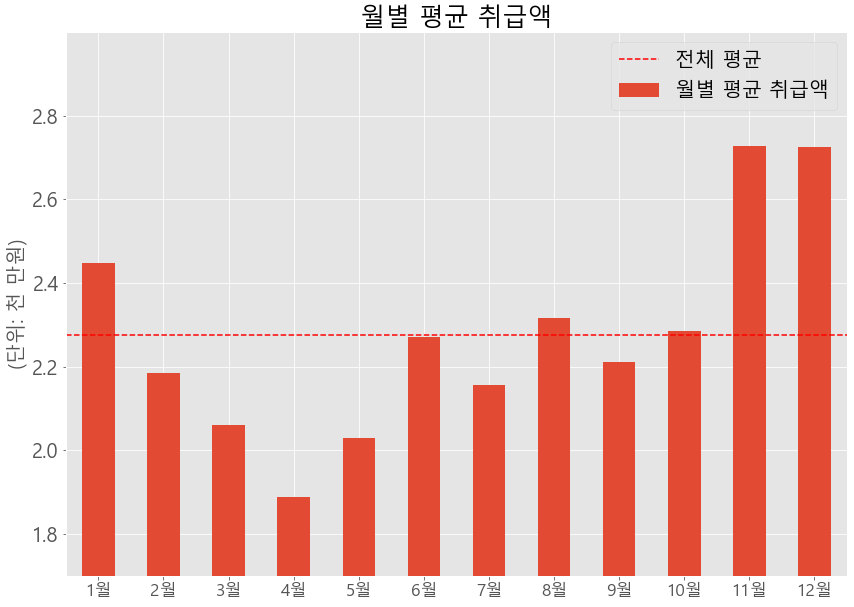

In [359]:
month_group = data['train']['2019'].groupby('월').mean()
month_group['col'] = [i for i in range(1, 13)]
month_group.plot.bar(y='취급액', figsize=(14, 10))#, label='col', colormap='Pastel1')
plt.axhline(y = np.mean(month_group.취급액), color = 'red', ls = '--')
plt.title('월별 평균 취급액', fontsize=25)
plt.xlabel('', fontsize=20)
plt.ylabel('(단위: 천 만원)', fontsize=20)
plt.xticks(ticks=[x-1 for x in range(1, 13)],
           labels=[f'{x}월' for x in range(1, 13)],
           fontsize=17, rotation=0)
plt.yticks(np.arange(0, 3e+7, step=2e+6),
           [f'{x/1e+7:.1f}' for x in np.arange(0, 3e+7, step=2e+6)],
           fontsize=20)
plt.grid(True)
plt.legend(labels=['전체 평균', '월별 평균 취급액'], prop={'size':20})
plt.ylim(month_group['취급액'].min()*0.9, month_group['취급액'].max()*1.1)
plt.show()

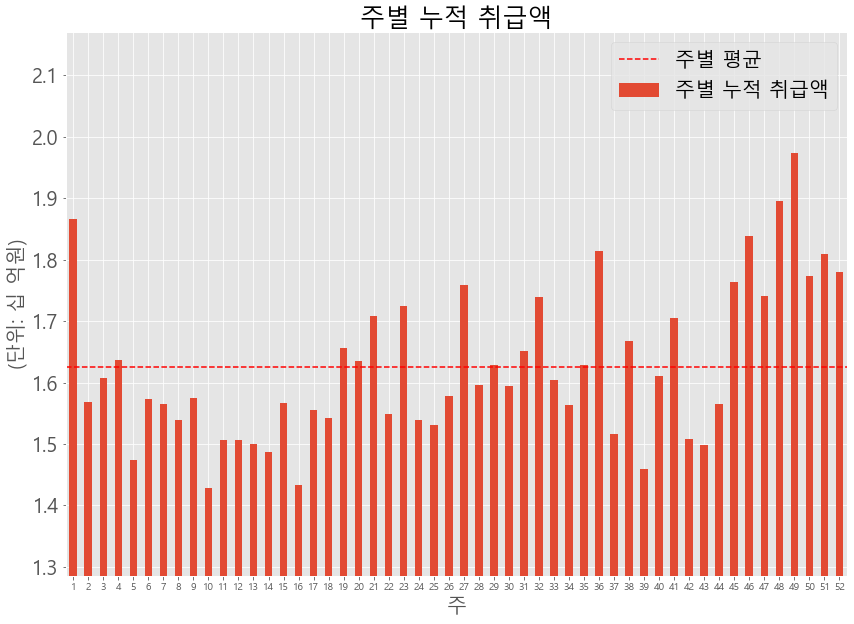

In [405]:
month_group = data['train']['2019'].groupby('주').sum()
month_group['취급액'].plot(kind='bar', figsize=(14, 10))
plt.axhline(y = np.mean(month_group.취급액), color = 'red', ls = '--')
plt.title('주별 누적 취급액', fontsize=25)
plt.xlabel('주', fontsize=20)
plt.ylabel('(단위: 십 억원)', fontsize=20)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(np.arange(0, 2.5e+10, step=1e+9),
           [f'{x/1e+10:.1f}' for x in np.arange(0, 2.5e+10, step=1e+9)],
           fontsize=20)
plt.grid(True)
plt.legend(labels=['주별 평균', '주별 누적 취급액'], prop={'size':20})
plt.ylim(month_group['취급액'].min()*0.9, month_group['취급액'].max()*1.1)
plt.show()

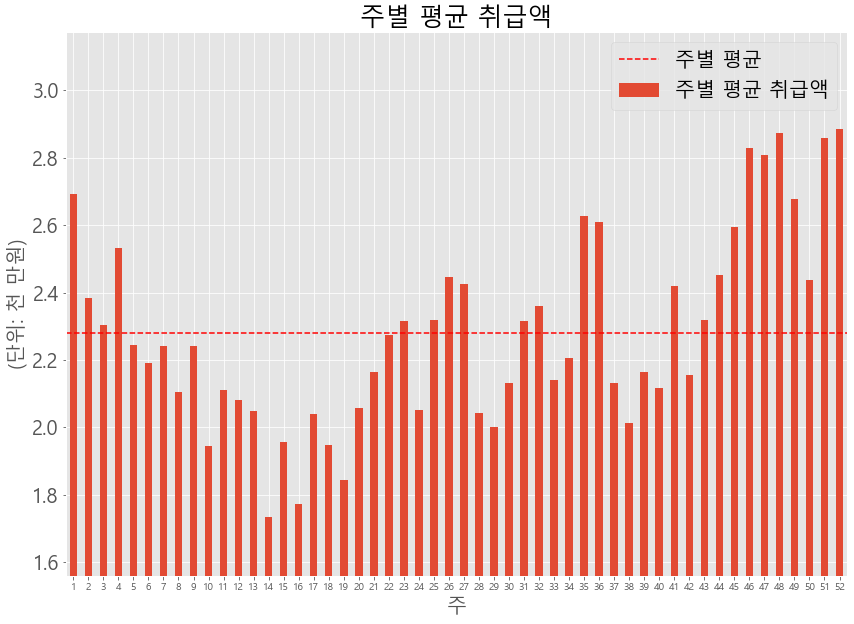

In [358]:
month_group = data['train']['2019'].groupby('주').mean()
month_group['취급액'].plot(kind='bar', figsize=(14, 10))
plt.axhline(y = np.mean(month_group.취급액), color = 'red', ls = '--')
plt.title('주별 평균 취급액', fontsize=25)
plt.xlabel('주', fontsize=20)
plt.ylabel('(단위: 천 만원)', fontsize=20)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(np.arange(0, 3.3e+7, step=2e+6),
           [f'{x/1e+7:.1f}' for x in np.arange(0, 3.3e+7, step=2e+6)],
           fontsize=20)
plt.grid(True)
plt.legend(labels=['주별 평균', '주별 평균 취급액'], prop={'size':20})
plt.ylim(month_group['취급액'].min()*0.9, month_group['취급액'].max()*1.1)
plt.show()

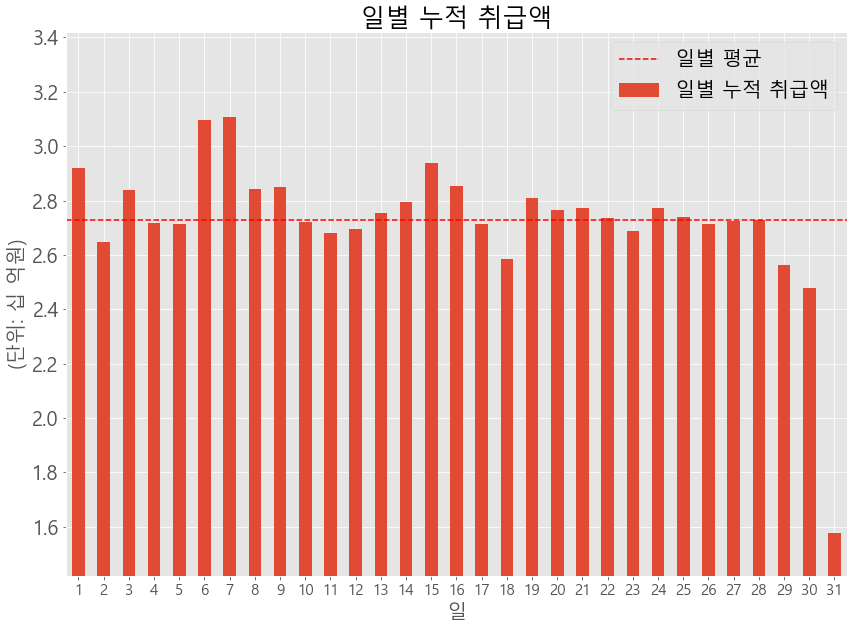

In [262]:
month_group = data['train']['2019'].groupby('일').sum()
month_group['취급액'].plot(kind='bar', figsize=(14, 10))
plt.axhline(y = np.mean(month_group.취급액), color = 'red', ls = '--')
plt.title('일별 누적 취급액', fontsize=25)
plt.xlabel('일', fontsize=20)
plt.ylabel('(단위: 십 억원)', fontsize=20)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(np.arange(0, 3.5e+10, step=2e+9),
           [f'{x/1e+10:.1f}' for x in np.arange(0, 3.5e+10, step=2e+9)],
           fontsize=20)
plt.grid(True)
plt.legend(labels=['일별 평균', '일별 누적 취급액'], prop={'size':20})
plt.ylim(month_group['취급액'].min()*0.9, month_group['취급액'].max()*1.1)
plt.show()

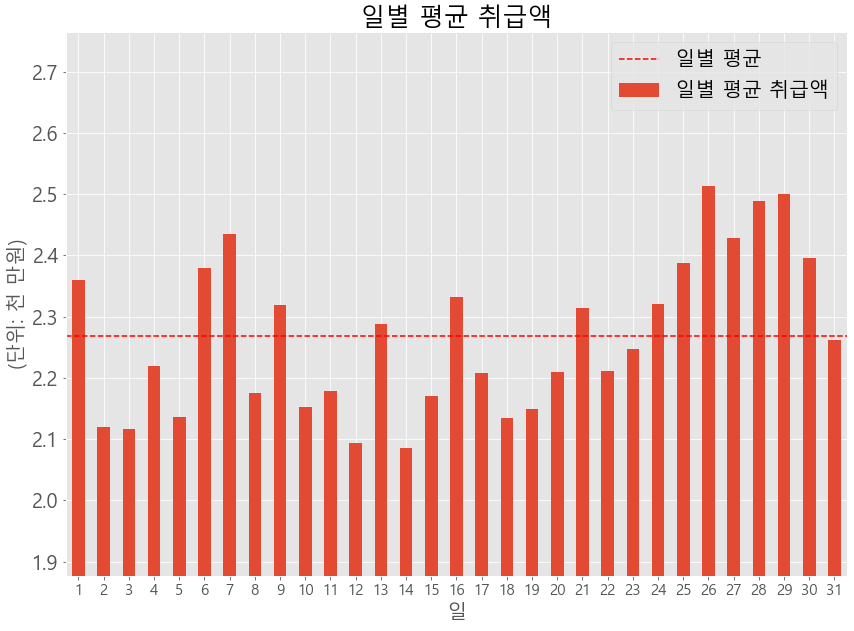

In [272]:
month_group = data['train']['2019'].groupby('일').mean()
month_group['취급액'].plot(kind='bar', figsize=(14, 10))
plt.axhline(y = np.mean(month_group.취급액), color = 'red', ls = '--')
plt.title('일별 평균 취급액', fontsize=25)
plt.xlabel('일', fontsize=20)
plt.ylabel('(단위: 천 만원)', fontsize=20)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(np.arange(0, 3e+7, step=1e+6),
           [f'{x/1e+7:.1f}' for x in np.arange(0, 3e+7, step=1e+6)],
           fontsize=20)
plt.grid(True)
plt.legend(labels=['일별 평균', '일별 평균 취급액'], prop={'size':20})
plt.ylim(month_group['취급액'].min()*0.9, month_group['취급액'].max()*1.1)
plt.show()

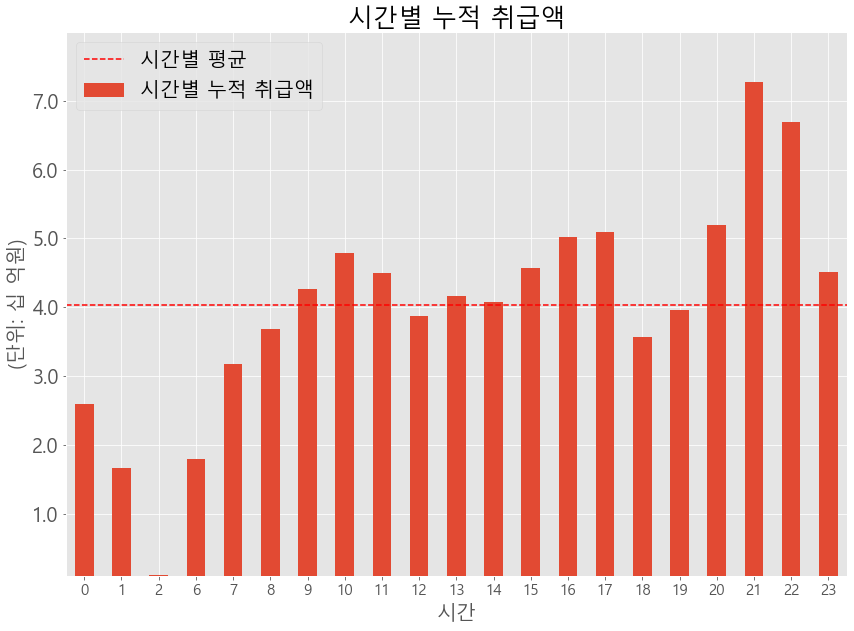

In [276]:
month_group = data['train']['2019'].groupby('시').sum()
month_group['취급액'].plot(kind='bar', figsize=(14, 10))
plt.axhline(y = np.mean(month_group.취급액), color = 'red', ls = '--')
plt.title('시간별 누적 취급액', fontsize=25)
plt.xlabel('시간', fontsize=20)
plt.ylabel('(단위: 십 억원)', fontsize=20)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(np.arange(0, 1e+11, step=1e+10),
           [f'{x/1e+10:.1f}' for x in np.arange(0, 1e+11, step=1e+10)],
           fontsize=20)
plt.grid(True)
plt.legend(labels=['시간별 평균', '시간별 누적 취급액'], prop={'size':20})
plt.ylim(month_group['취급액'].min()*0.9, month_group['취급액'].max()*1.1)
plt.show()

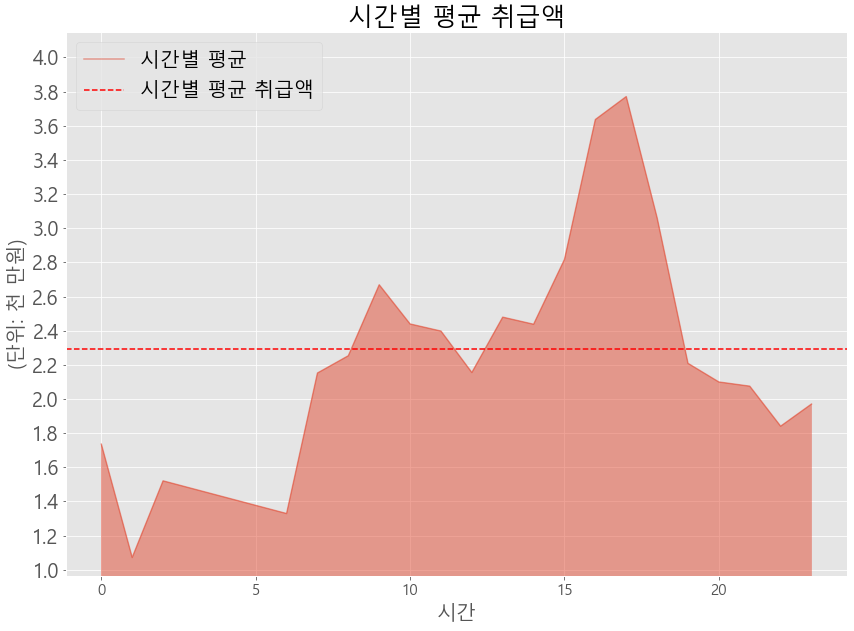

In [401]:
month_group = data['train']['2019'].groupby('시').mean()
month_group['취급액'].plot(kind='', figsize=(14, 10), alpha=.5)
plt.axhline(y = np.mean(month_group.취급액), color = 'red', ls = '--')
plt.title('시간별 평균 취급액', fontsize=25)
plt.xlabel('시간', fontsize=20)
plt.ylabel('(단위: 천 만원)', fontsize=20)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(np.arange(0, 4.4e+7, step=2e+6),
           [f'{x/1e+7:.1f}' for x in np.arange(0, 4.4e+7, step=2e+6)],
           fontsize=20)
plt.grid(True)
plt.legend(labels=['시간별 평균', '시간별 평균 취급액'], prop={'size':20})
plt.ylim(month_group['취급액'].min()*0.9, month_group['취급액'].max()*1.1)
plt.show()

# 상품군별 노출(분)

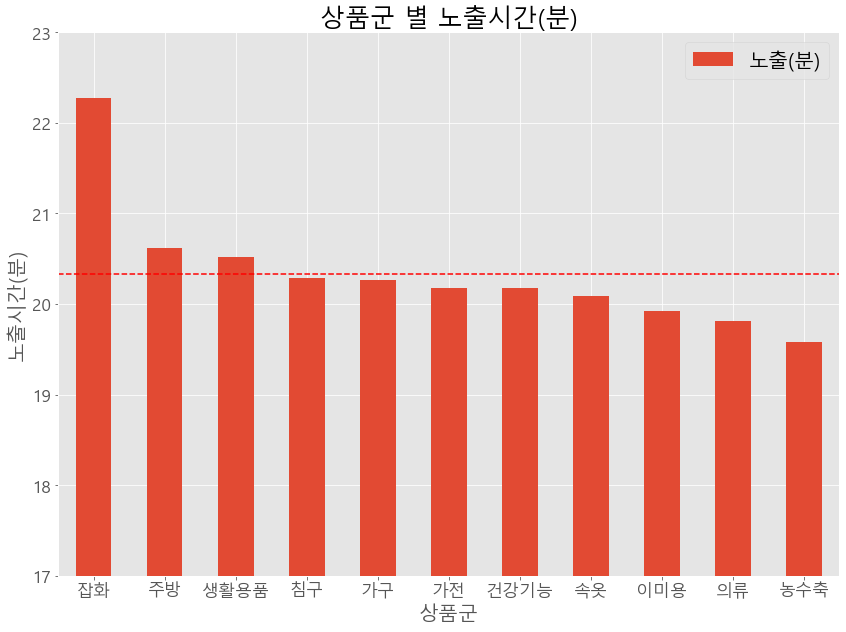

In [370]:
cat_duration = data['train'][['상품군', '노출(분)']].groupby('상품군').mean()
cat_duration.sort_values(by=['노출(분)'], axis=0, ascending=False).plot(kind='bar', figsize=(14, 10))
plt.axhline(y = np.mean(cat_duration['노출(분)']), color = 'red', ls = '--')
plt.title('상품군 별 노출시간(분)', fontsize=25)
plt.xlabel('상품군', fontsize=20)
plt.xticks(rotation=0, fontsize=17)
plt.ylabel('노출시간(분)', fontsize=20)
plt.yticks(fontsize=17)
plt.legend(prop={'size':20})

plt.ylim(17,23)
plt.show()

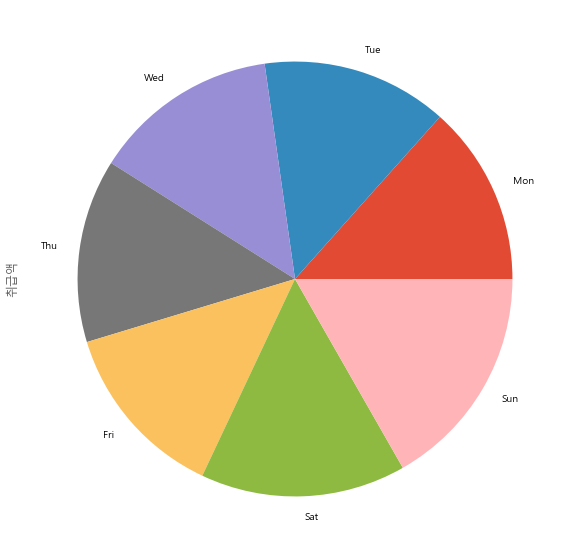

In [408]:
weekday_group = data['train']['2019'].groupby('요일').sum()
weekday_group = weekday_group.T.loc['취급액',['Mon','Tue','Wed','Thu','Fri','Sat','Sun']]
weekday_group.plot(kind='pie', figsize=(14, 10)) #0: Monday ~ 6: Sunday

#plt.axhline(y = np.mean(weekday_group), color = 'red', ls = '--')

#plt.ylim(weekday_group.min()*0.9, weekday_group.max()*1.1)
plt.show()

In [250]:
import plotly.express as px

In [251]:
df = month_group

In [253]:
fig = px.pie(df, values='취급액', names=df.index, title='상품군의 총 취급액 비율', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

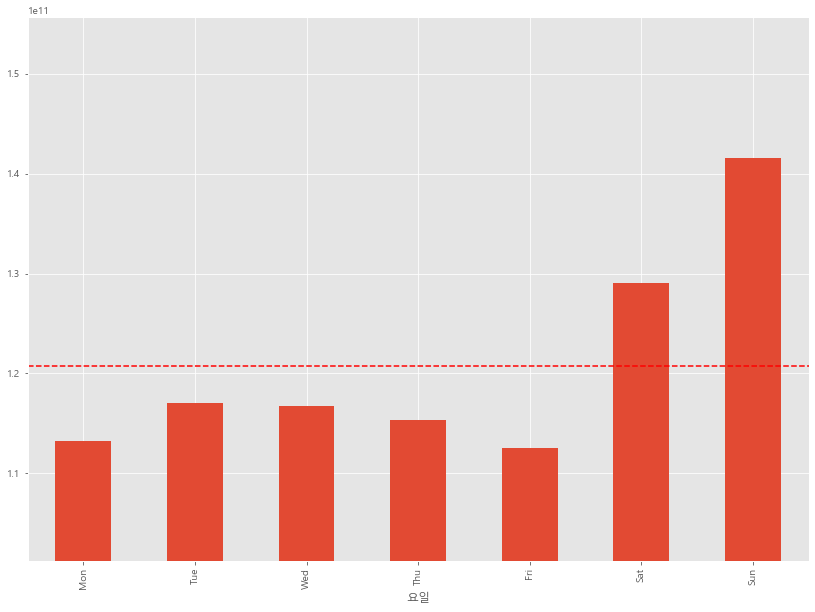

In [378]:
weekday_group = data['train']['2019'].groupby('요일').sum()

In [379]:
weekday_group

,노출(분),마더코드,상품코드,판매단가,취급액,연,월,주,일,시,분
요일,,,,,,,,,,,
Fri,106173.8000,523260610,1048761029,2402628550,112511521000.0000,10523028,33366,135117,78291,73853,103600
Mon,107175.3833,525801086,1053923377,2102735000,113211536000.0000,10573503,34896,141090,78461,75593,104290
Sat,106649.8500,520077011,1042274004,2782930850,129058504000.0000,10462458,33203,134158,80799,73421,106700
Sun,112920.4500,558941785,1120295503,3109169200,141527843000.0000,11241792,35816,143807,85635,80988,113520
Thu,107326.9333,533233562,1068708032,2334268000,115304816000.0000,10724928,34148,139812,84672,75824,105980
Tue,110871.1167,544268245,1090977357,2241068000,117021704000.0000,10944999,35448,141323,83507,77811,107740
Wed,110594.3500,545772218,1093945495,2516665900,116743171000.0000,10975284,34664,142101,83055,77247,108260


In [395]:
fig = px.pie(weekday_group, values='취급액', names=weekday_group.index,
             title='상품군의 총 취급액 비율',
             color_discrete_sequence=px.colors.sequential.RdBu,
            )
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [393]:
import plotly.graph_objects as go

labels = ['Oxygen','Hydrogen','Carbon_Dioxide','Nitrogen']
values = [4500, 2500, 1053, 500]

# pull is given as a fraction of the pie radius
fig = go.Figure(data=[go.Pie(
    labels=weekday_group.index,
    values=weekday_group.취급액,
    pull=[0, 0, 0, 0.2, 0, 0, 0],
    textinfo='label+percent',
     title='요일별 취급액 비율',
     titleposition='middle center',)
                      
])
fig.show()

ValueError: Invalid property specified for object of type plotly.graph_objs.Pie: 'color_discrete_sequence'

    Valid properties:
        automargin
            Determines whether outside text labels can push the
            margins.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            customdata .
        direction
            Specifies the direction at which succeeding sectors
            follow one another.
        dlabel
            Sets the label step. See `label0` for more info.
        domain
            :class:`plotly.graph_objects.pie.Domain` instance or
            dict with compatible properties
        hole
            Sets the fraction of the radius to cut out of the pie.
            Use this to make a donut chart.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            hoverinfo .
        hoverlabel
            :class:`plotly.graph_objects.pie.Hoverlabel` instance
            or dict with compatible properties
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}". https://github.com/d3/d3-3.x-api-
            reference/blob/master/Formatting.md#d3_format for
            details on the formatting syntax. Dates are formatted
            using d3-time-format's syntax %{variable|d3-time-
            format}, for example "Day: %{2019-01-01|%A}".
            https://github.com/d3/d3-time-format#locale_format for
            details on the date formatting syntax. The variables
            available in `hovertemplate` are the ones emitted as
            event data described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available. variables `label`, `color`, `value`,
            `percent` and `text`. Anything contained in tag
            `<extra>` is displayed in the secondary box, for
            example "<extra>{fullData.name}</extra>". To hide the
            secondary box completely, use an empty tag
            `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            hovertemplate .
        hovertext
            Sets hover text elements associated with each sector.
            If a single string, the same string appears for all
            data points. If an array of string, the items are
            mapped in order of this trace's sectors. To be seen,
            trace `hoverinfo` must contain a "text" flag.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            hovertext .
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            ids .
        insidetextfont
            Sets the font used for `textinfo` lying inside the
            sector.
        insidetextorientation
            Controls the orientation of the text inside chart
            sectors. When set to "auto", text may be oriented in
            any direction in order to be as big as possible in the
            middle of a sector. The "horizontal" option orients
            text to be parallel with the bottom of the chart, and
            may make text smaller in order to achieve that goal.
            The "radial" option orients text along the radius of
            the sector. The "tangential" option orients text
            perpendicular to the radius of the sector.
        label0
            Alternate to `labels`. Builds a numeric set of labels.
            Use with `dlabel` where `label0` is the starting label
            and `dlabel` the step.
        labels
            Sets the sector labels. If `labels` entries are
            duplicated, we sum associated `values` or simply count
            occurrences if `values` is not provided. For other
            array attributes (including color) we use the first
            non-empty entry among all occurrences of the label.
        labelssrc
            Sets the source reference on Chart Studio Cloud for
            labels .
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        marker
            :class:`plotly.graph_objects.pie.Marker` instance or
            dict with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            meta .
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        opacity
            Sets the opacity of the trace.
        outsidetextfont
            Sets the font used for `textinfo` lying outside the
            sector.
        pull
            Sets the fraction of larger radius to pull the sectors
            out from the center. This can be a constant to pull all
            slices apart from each other equally or an array to
            highlight one or more slices.
        pullsrc
            Sets the source reference on Chart Studio Cloud for
            pull .
        rotation
            Instead of the first slice starting at 12 o'clock,
            rotate to some other angle.
        scalegroup
            If there are multiple pie charts that should be sized
            according to their totals, link them by providing a
            non-empty group id here shared by every trace in the
            same group.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        sort
            Determines whether or not the sectors are reordered
            from largest to smallest.
        stream
            :class:`plotly.graph_objects.pie.Stream` instance or
            dict with compatible properties
        text
            Sets text elements associated with each sector. If
            trace `textinfo` contains a "text" flag, these elements
            will be seen on the chart. If trace `hoverinfo`
            contains a "text" flag and "hovertext" is not set,
            these elements will be seen in the hover labels.
        textfont
            Sets the font used for `textinfo`.
        textinfo
            Determines which trace information appear on the graph.
        textposition
            Specifies the location of the `textinfo`.
        textpositionsrc
            Sets the source reference on Chart Studio Cloud for
            textposition .
        textsrc
            Sets the source reference on Chart Studio Cloud for
            text .
        texttemplate
            Template string used for rendering the information text
            that appear on points. Note that this will override
            `textinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}". https://github.com/d3/d3-3.x-api-
            reference/blob/master/Formatting.md#d3_format for
            details on the formatting syntax. Dates are formatted
            using d3-time-format's syntax %{variable|d3-time-
            format}, for example "Day: %{2019-01-01|%A}".
            https://github.com/d3/d3-time-format#locale_format for
            details on the date formatting syntax. Every attributes
            that can be specified per-point (the ones that are
            `arrayOk: true`) are available. variables `label`,
            `color`, `value`, `percent` and `text`.
        texttemplatesrc
            Sets the source reference on Chart Studio Cloud for
            texttemplate .
        title
            :class:`plotly.graph_objects.pie.Title` instance or
            dict with compatible properties
        titlefont
            Deprecated: Please use pie.title.font instead. Sets the
            font used for `title`. Note that the title's font used
            to be set by the now deprecated `titlefont` attribute.
        titleposition
            Deprecated: Please use pie.title.position instead.
            Specifies the location of the `title`. Note that the
            title's position used to be set by the now deprecated
            `titleposition` attribute.
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        values
            Sets the values of the sectors. If omitted, we count
            occurrences of each label.
        valuessrc
            Sets the source reference on Chart Studio Cloud for
            values .
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        